# Can we use the VFA method in OE-MRI?
This notebook has the theoretical background of the Variable Flip Angle (VFA) method to measure T1. It will expand in the requirements to use this technique to measure T1 changes in lung due to changes in the oxygen concentration.

## Signal equation and VFA method
The variable flip angle method is derived from the signal equation of the spoiled gradient-echo sequence (SPGR). There are a lot of literature available about this method, so in this notebook I'll try to cover the major and earlier paper providing the mathematical framework of this method.

### SPGR signal equation
\begin{eqnarray}
S(T_1, T_R, \alpha, M_0) & = & M_0\sin(\alpha)\frac{1 - E_1(T_1,T_R)}{1 - E_1(T_1,T_R)\cos(\alpha)} \label{spgr} \\
E_1(T_1, T_R) & = & \exp(-T_R/T_1)
\end{eqnarray}

If we acquire multiple flip angles, keeping everything else constant, the equation \ref{spgr} can be linearised and T1 derived from the slope of such line:

\begin{eqnarray}
\frac{S_i}{\sin(\alpha_i)} & = & E_1\frac{S_i}{\tan(\alpha_i)} + M_0(1-E_1) \\
\hat{Y}[i] & = & m\hat{X}[i] + n
\end{eqnarray}

with:
\begin{eqnarray}
\hat{Y}[i] & = & \frac{S_i}{\sin(\alpha_i)} \\
\hat{X}[i] & = & \frac{S_i}{\tan(\alpha_i)} \\
m & = & E_1 \\ 
n & = & M_0(1-E1)
\end{eqnarray}

from which we can derived $T_1$ from the slope $m$:
\begin{eqnarray}
E_1 & = & m \\
E_1 & = & \exp(-T_R/T_1) \\ 
-\frac{T_R}{T_1} & = & \ln(E_1) \\
T_1 & = & -\frac{T_R}{\ln(m)}
\end{eqnarray}

However, in practice, we acquire multiple repetitions for each angles and do a non-linear fit of equation \ref{spgr}.

### Maximum Difference between 2 T1's
We want to identify the flip angle which maximises the difference in signal between two samples with slightly different T1 (we assume the proton density is kept constant for both T1's).

\begin{eqnarray}
S(T_1^{A}) & = & M_0\sin(\alpha)\frac{1 - E_1(T_1^{A}, T_R)}{1 - \cos(\alpha) E_1(T_1^{A}, T_R)} \\
S(T_1^{B}) & = & M_0\sin(\alpha)\frac{1 - E_1(T_1^{B}, T_R)}{1 - \cos(\alpha) E_1(T_1^{B}, T_R)} \\
\end{eqnarray}

$$ \Delta S(T_1) = M_0\sin(\alpha)\biggr[\frac{1 - E_1(T_1^{A}, T_R)}{1 - \cos(\alpha) E_1(T_1^{A}, T_R)} - \frac{1 - E_1(T_1^{B}, T_R)}{1 - \cos(\alpha) E_1(T_1^{B}, T_R)} \biggl]$$

We can also look at the ratio between $S(T_1^{A})$ and $S(T_1^{B})$ and determine for which flip angle it is maximised:
$$ \mbox{ratio } S(T_1) = \frac{(1 - E_1(T_1^{A}, T_R))(1 - \cos(\alpha) E_1(T_1^{B}, T_R))}{(1 - E_1(T_1^{B}, T_R))(1 - \cos(\alpha) E_1(T_1^{A}, T_R))}$$

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def E1(TR, T1):
    
    return np.exp(-TR/T1)

def fzss(TR, T1, FA):
    
    return (1.0 - E1(TR, T1))/(1.0 - np.cos(np.deg2rad(FA))*E1(TR, T1))

def st(TR, T1, M0, FA):
    
    return M0*np.sin(np.deg2rad(FA))*fzss(TR, T1, FA)

def dst1(T1A, T1B, TR, M0, FA):
    
    ST1A = st(TR, T1A, M0, FA)
    ST1B = st(TR, T1B, M0, FA)
    
    return ST1A - ST1B, ST1A, ST1B

def rst1(T1A, T1B, TR, FA):
    
    ratioST1 = fzss(TR, T1A, FA)/fzss(TR, T1B, FA)
    
    return ratioST1

def maxDsignal(T1A, T1B, TR, FA):
    
    delta_st1 = dst1(T1A, T1B, TR, 1.0, FA)[0]
    
    return FA[delta_st1 == delta_st1.max()][0]

def ernstAngle(TR, T1):
    # Flip Angle that maximises the signal for a given TR and T1 (REF: Handbook of MRI Pulse Sequences, page 587, Eq. 14.9)
    
    return np.rad2deg(np.arccos(E1(TR, T1)))

def anglesT1Maps(TR,T1):
    # Flip angles for optimal T1 Mapping with only 2 acq (REF: Deoni SCL 2003, Rapid Combined T1 and T2 mapping using..., MRM 49:515-526)
    
    f = 0.71 # see REF
    angle1 = (E1(TR, T1)*np.square(f) + (1-np.square(E1(TR, T1)))*np.sqrt(1-np.square(f)))/(1-(np.square(E1(TR, T1))*(1-np.square(f))))
    angle2 = (E1(TR, T1)*np.square(f) - (1-np.square(E1(TR, T1)))*np.sqrt(1-np.square(f)))/(1-(np.square(E1(TR, T1))*(1-np.square(f))))
    Angles = np.array([angle1,angle2])
    #return Angles
    return np.rad2deg(np.arccos(Angles))

def E2(TE, T2):
    
    return np.exp(-TE/T2)


def stComplete(TR, T1, M0, FA, TE, T2):
    #eq  with t2 decay
    return st(TR, T1, M0, FA)*E2(TE,T2)

def dstlComplete(T1A, T1B, TR, M0, FA, TE, T2A, T2B):
    ST1AComplete = stComplete(TR, T1A, M0, FA, TE, T2A)
    ST1BComplete = stComplete(TR, T1B, M0, FA, TE, T2B)
    
    return ST1AComplete - ST1BComplete, ST1AComplete, ST1BComplete

def rst1Complete(T1A, T1B, TR, M0, FA, TE, T2A, T2B):
    ratioST1Complete = stComplete(TR, T1A, M0, FA, TE, T2A)/stComplete(TR, T1B, M0, FA, TE, T2B)
    
    return ratioST1Complete

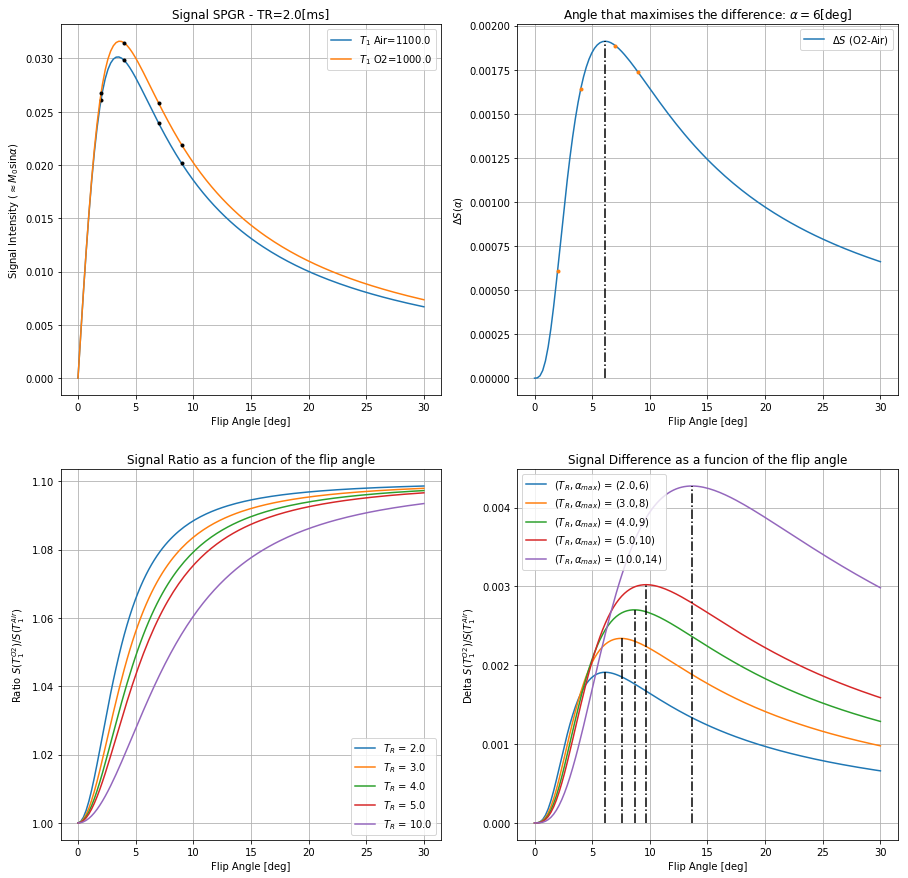

In [4]:
maxFA = 30.0
alpha = np.linspace(0.0, maxFA, num=128)

TR = 2.0 # ms
TE = 0.5 # ms
M0 = 1.0

T1 = {'Air':1100.0, 'O2':1000.0}
DELTA_ST1, ST1A, ST1B = dst1(T1['O2'], T1['Air'], TR, M0, alpha)
RATIO_ST1 = rst1(T1['O2'], T1['Air'], TR, alpha)
maxALPHA = alpha[DELTA_ST1 == DELTA_ST1.max()]


OEFA =  [2.0, 4.0, 7.0, 9.0]
DELTA_ST1OE, STA_OEMRI, STB_OEMRI = dst1(T1['O2'], T1['Air'], TR, M0, OEFA)
RATIO_ST1OE= rst1(T1['O2'], T1['Air'], TR,  alpha)


plt.figure(1, figsize=(15.0,15.0))
plt.subplot(2,2,1)
for sample, indivt1 in T1.items():
    plt.plot(alpha, st(TR, indivt1, M0, alpha), label=r'$T_1$ {0:s}={1:0.1f}'.format(sample, indivt1))
    plt.plot(OEFA, st(TR, indivt1, M0, OEFA), 'k.')

plt.grid()
plt.xlabel('Flip Angle [deg]')
plt.ylabel('Signal Intensity '+r'$(\approx M_0\sin\alpha)$')
plt.legend(loc='best')
plt.title('Signal SPGR - TR={0:.1f}[ms]'.format(TR))

plt.subplot(2,2,2)
plt.plot(alpha, DELTA_ST1, label=r'$\Delta S$ ({}-{})'.format('O2','Air'))
plt.plot([maxALPHA]*2, [0.0, DELTA_ST1.max()],'k-.')
plt.plot(OEFA, DELTA_ST1OE,'.')
plt.plot()
plt.grid()
plt.ylabel(r'$\Delta S(\alpha)$')
plt.xlabel('Flip Angle [deg]')
plt.legend(loc='best')
plt.title('Angle that maximises the difference: ' + r'$\alpha=$' + '{0:.0f}[deg]'.format(maxALPHA[0]))

TRlist = [2.0, 3.0, 4.0, 5.0, 10.0]
plt.subplot(2,2,3)
for trep in TRlist:
    plt.plot(alpha, rst1(T1['O2'], T1['Air'], trep, alpha), label=r'$T_{R}$'+' = {0:.1f}'.format(trep))
plt.legend(loc='best')
plt.xlabel('Flip Angle [deg]')
plt.ylabel('Ratio ' + r'$S(T_{1}^{O2})/S(T_{1}^{Air})$')
plt.title('Signal Ratio as a funcion of the flip angle')
plt.grid()

plt.subplot(2,2,4)
for trep in TRlist:
    dsaux = dst1(T1['O2'], T1['Air'], trep, M0, alpha)[0]
    maxalph = alpha[dsaux == dsaux.max()][0]
    plt.plot(alpha, dsaux, label=r'$(T_{R},\alpha_{max})$'+' = ({0:.1f},{1:.0f})'.format(trep,maxalph))
    plt.plot([maxalph]*2, [0.0, dsaux.max()], 'k-.')
plt.legend(loc='best')
plt.xlabel('Flip Angle [deg]')
plt.ylabel('Delta ' + r'$S(T_{1}^{O2})/S(T_{1}^{Air})$')
plt.title('Signal Difference as a funcion of the flip angle')
plt.grid()


plt.show()


From the simulations above we observe the following:
* The maximum expected signal change from 21% to 100% oxygen is only 10% (i.e. signal ratio grows asymptotically with the flip angle up to 1.1)
* The signal ratio is inversely proportional to the TR
* Larger TR's provide better SNR (T1W sequence)
* The maximum signal difference increases when the pair (Flip Angle, TR) both increase

We need to find the best trade-off between SNR (i.e. long TR) and signal contrast (i.e. Flip Angle & TR) for both T1. We also have to take into account that any increase in TR will affect the total acquisition time. We need to keep this total time within the feasible ranges (i.e. compatible with physiology).

Therefore:
* Maximum readout time should not exceed 3-4s per volume
* TR=4ms, FA=9deg and parallel imaging reductions could provides a good trade-off between SNR and acquisition time e.g. for a 112x(88/2)x18 acquisition matrix, the total acquisition time would be roughly 44x18x4ms ~3.2 sec

The following cells will provide these calculations for a given set of parameters

	[Nx, Ny, Nz]:		[112, 88, 18] (2.0x Acceleration Factor)
	[TR[ms], FA[deg]]:	[10.0, 14.0]
	[T1air, T1o2][ms]:	[1100.0, 1000.0]
The main results are:
* The expected signal difference is:	0.0043
* The expected signal ratio is :	1.0751 (7.51%)
* The estimated acquisition time is:	7.92[s] per volume (79.20[s] per 10 repetitions)


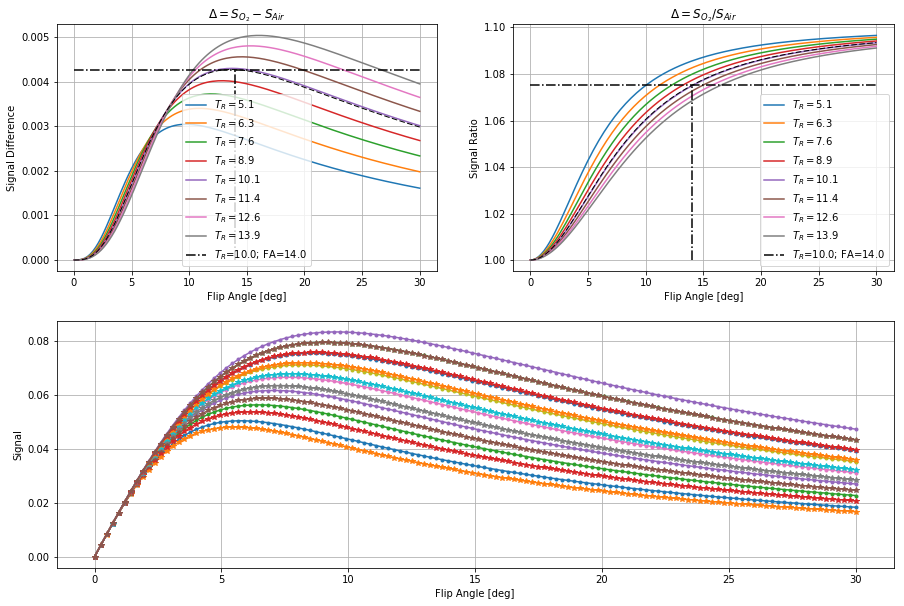

In [5]:
# Acquisition Matrix
Nx = 112
Ny = 88
Nz = 18

# Acceleration Factor
RFold = 2.0

# Number of Repetitions
nrep = 10

# Sample T1s
ET1 = {'Air': 1100.0, 'O2':1000.0}

# Sequence Parameters
TE = 0.86 #ms
TR = 10.0#ms
FA = maxDsignal(ET1['O2'], ET1['Air'], TR, np.linspace(0.0, 90.0, num=91)) #deg

Dsignal, Sair, So2 = dst1(ET1['O2'], ET1['Air'], TR, 1.0, FA)
Rsignal = rst1(ET1['O2'], ET1['Air'], TR, FA)

# Estimated Acquisition Time:
AcqTime = 1e-3*TR*Ny*Nz/RFold
FATime  = nrep*AcqTime

print('\t[Nx, Ny, Nz]:\t\t[{0:d}, {1:d}, {2:d}] ({3:.1f}x Acceleration Factor)'.format(Nx, Ny, Nz, RFold))
print('\t[TR[ms], FA[deg]]:\t[{0:.1f}, {1:.1f}]'.format(TR, FA))
print('\t[T1air, T1o2][ms]:\t[{0:.1f}, {1:.1f}]'.format(ET1['Air'], ET1['O2']))
print('The main results are:')
print('* The expected signal difference is:\t{0:.4f}'.format(Dsignal))
print('* The expected signal ratio is :\t{0:.4f} ({1:.2f}%)'.format(Rsignal, 100*(Rsignal-1.0)))
print('* The estimated acquisition time is:\t{0:.2f}[s] per volume ({1:.2f}[s] per {2:d} repetitions)'.format(AcqTime, FATime, nrep))

# Sensitivity Analysis
nsamples = 128
nskip    = 16

TRlb = (0.5*TR)
TRub = (1.5*TR)
RepTime = np.linspace(TRlb, TRub, num=nsamples)

FAlb = 0.0
FAub = 30.0
FlipAngles = np.linspace(FAlb, FAub, num=nsamples)

nfa0 = np.nonzero(FlipAngles>=1.0)[0][0]
plt.figure(1, figsize=(15.0, 10.0))

ntr0 = 1#np.nonzero(RepTime > (0.5*TR))[0][0]
for indtr, currtr in enumerate(RepTime[ntr0::nskip]):
    Dst_fa, Sair_fa, So2_fa = dst1(ET1['O2'], ET1['Air'], currtr, 1.0, FlipAngles)
    Rst_fa = rst1(ET1['O2'], ET1['Air'], currtr, FlipAngles)
    plt.subplot(2,2,1)
    plt.plot(FlipAngles, Dst_fa, label=r'$T_R=${0:.1f}'.format(currtr))
    plt.subplot(2,2,2)
    plt.plot(FlipAngles, Rst_fa, label=r'$T_R=${0:.1f}'.format(currtr))
    plt.subplot(2,1,2)
    plt.plot(FlipAngles, Sair_fa, '.-', label=r'$T_R=${0:.1f}'.format(currtr))
    plt.plot(FlipAngles, So2_fa, '*-', label=r'$T_R=${0:.1f}'.format(currtr))


plt.subplot(2,2,1)
plt.plot([FA]*2, [0.0, Dsignal],'k-.', label=r'$T_R$={0:.1f}; FA={1:.1f}'.format(TR, FA))
plt.plot(FlipAngles, [Dsignal]*nsamples,'k-.')
plt.plot(FlipAngles, dst1(ET1['O2'], ET1['Air'], TR, 1.0, FlipAngles)[0],'k--', linewidth=1.0)
plt.legend(loc='best')
plt.xlabel('Flip Angle [deg]')
plt.ylabel('Signal Difference')
plt.title(r'$\Delta=S_{O_2}-S_{Air}$')
plt.grid()

plt.subplot(2,2,2)
plt.plot([FA]*2, [1.0, Rsignal],'k-.', label=r'$T_R$={0:.1f}; FA={1:.1f}'.format(TR, FA))
plt.plot(FlipAngles, [Rsignal]*nsamples,'k-.')
plt.plot(FlipAngles, rst1(ET1['O2'], ET1['Air'], TR, FlipAngles),'k--', linewidth=1.0)
plt.legend(loc='best')
plt.xlabel('Flip Angle [deg]')
plt.ylabel('Signal Ratio')
plt.title(r'$\Delta=S_{O_2}/S_{Air}$')
plt.grid()

plt.subplot(2,1,2)
plt.grid()
plt.xlabel('Flip Angle [deg]')
plt.ylabel('Signal')


plt.show()

The Ernst angle for TR=1.9 and T1 = 1100 is 	3.4
The 2 suggested angles for T1 mapping are 	2.3 	13.1


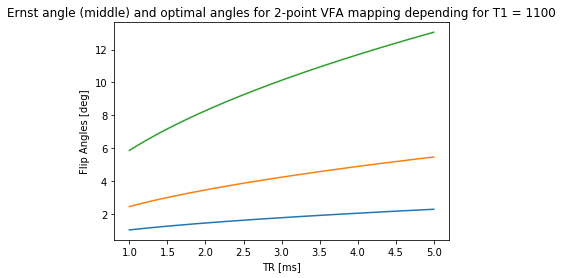

In [6]:
ErnstAngle = ernstAngle(1.9, 1100)
AnglesMap = anglesT1Maps(1.9, 1100)

SizeArray=500
AllTR = np.linspace(1,5,SizeArray)
AllAngles = np.zeros((SizeArray,3))
counter=0
for trep in AllTR:
    AnglesMap = anglesT1Maps(trep, 1100)
    AllAngles[counter,0]= float(AnglesMap[0])
    AllAngles[counter,1]= float(ernstAngle(trep, 1100))
    AllAngles[counter,2]= float(AnglesMap[1])
    counter=counter+1

print('The Ernst angle for TR=1.9 and T1 = 1100 is \t{0:.1f}'.format(ErnstAngle))
print('The 2 suggested angles for T1 mapping are \t{0:.1f} \t{1:.1f}'.format(AnglesMap[0],AnglesMap[1]))
plt.plot(AllTR,AllAngles)
plt.xlabel('TR [ms]')
plt.ylabel('Flip Angles [deg]')
plt.title('Ernst angle (middle) and optimal angles for 2-point VFA mapping depending for T1 = 1100')



Inhaling oxygen, T2* changes are also expected alongside T1 changes. 
In order to simulate this, the T2* decay component must be added to the SPGR equation. Values were taken from 'Multiparametric oxygen-enhanced functional lung imaging in 3D', Hemberger et al, 2014.

Overall, T2* decay further decrease the expected difference in signal intensity between the two acquisition, about half. The differences is even inverted at low flip angles (<2.5 degree).

ratio is 	0.9791


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in true_divide


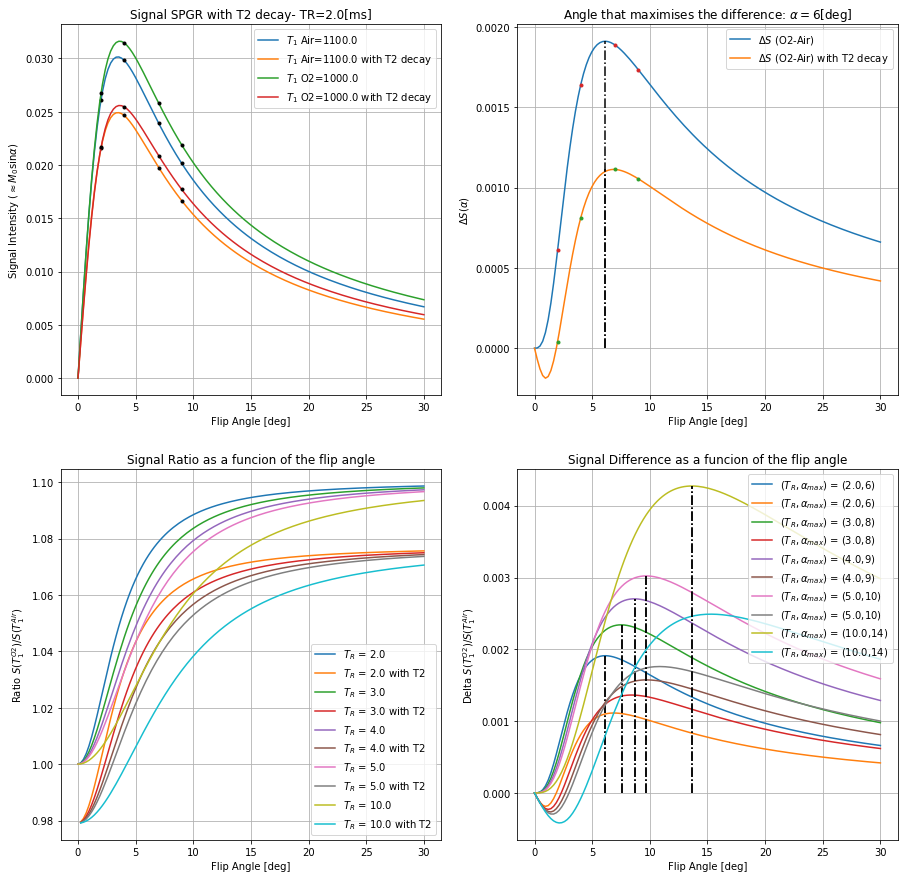

In [10]:
maxFA = 30.0
alpha = np.linspace(0.0, maxFA, num=128)

TR = 2.0 # ms
TE = 0.4 # ms
M0 = 1.0

T1 = {'Air':1100.0, 'O2':1000.0}
T2 = {'Air':2.10, 'O2':1.89} # [ms] from Hemberger 2014
RatioE2 = E2(TE,T2['O2'])/E2(TE,T2['Air'])
print('ratio is \t{0:.4f}'.format(RatioE2))

DELTA_ST1_Com, ST1A_Com, ST1B_Com = dstlComplete(T1['O2'], T1['Air'], TR, M0, alpha, TE, T2['O2'], T2['Air'])
RATIO_ST1_Com = rst1Complete(T1['O2'], T1['Air'], TR, M0, alpha, TE, T2['O2'], T2['Air'])
maxALPHA_com = alpha[DELTA_ST1_Com == DELTA_ST1_Com.max()]
maxALPHA_com = alpha[DELTA_ST1 == DELTA_ST1.max()]

OEFA =  [2.0, 4.0, 7.0, 9.0]
DELTA_ST1OE_Com, STA_OEMRI_Com, STB_OEMRI_Com = dstlComplete(T1['O2'], T1['Air'], TR, M0, OEFA, TE, T2['O2'], T2['Air'])
RATIO_ST1OE_Com = rst1Complete(T1['O2'], T1['Air'], TR, M0, alpha, TE, T2['O2'], T2['Air'])

plt.figure(1, figsize=(15.0,15.0))
plt.subplot(2,2,1)
for sample, indivt1 in T1.items():
    plt.plot(alpha, st(TR, indivt1, M0, alpha), label=r'$T_1$ {0:s}={1:0.1f}'.format(sample, indivt1))
    plt.plot(OEFA, st(TR, indivt1, M0, OEFA), 'k.')
    plt.plot(alpha, stComplete(TR, indivt1, M0, alpha, TE, T2[sample]), label=r'$T_1$ {0:s}={1:0.1f} with T2 decay'.format(sample, indivt1))
    plt.plot(OEFA, stComplete(TR, indivt1, M0, OEFA, TE, T2[sample]), 'k.')
    
plt.grid()
plt.xlabel('Flip Angle [deg]')
plt.ylabel('Signal Intensity '+r'$(\approx M_0\sin\alpha)$')
plt.legend(loc='best')
plt.title('Signal SPGR with T2 decay- TR={0:.1f}[ms]'.format(TR))

plt.subplot(2,2,2)
plt.plot(alpha, DELTA_ST1, label=r'$\Delta S$ ({}-{})'.format('O2','Air'))
plt.plot([maxALPHA]*2, [0.0, DELTA_ST1.max()],'k-.')
plt.plot(alpha, DELTA_ST1_Com, label=r'$\Delta S$ ({}-{}) with T2 decay'.format('O2','Air'))
plt.plot([maxALPHA_com]*2, [0.0, DELTA_ST1_Com.max()],'k-.')
plt.plot(OEFA, DELTA_ST1OE_Com,'.')
plt.plot(OEFA, DELTA_ST1OE,'.')
plt.plot()
plt.grid()
plt.ylabel(r'$\Delta S(\alpha)$')
plt.xlabel('Flip Angle [deg]')
plt.legend(loc='best')
plt.title('Angle that maximises the difference: ' + r'$\alpha=$' + '{0:.0f}[deg]'.format(maxALPHA[0]))

TRlist = [2.0, 3.0, 4.0, 5.0, 10.0]
plt.subplot(2,2,3)
for trep in TRlist:
    plt.plot(alpha, rst1(T1['O2'], T1['Air'], trep, alpha), label=r'$T_{R}$'+' = {0:.1f}'.format(trep))
    plt.plot(alpha, rst1Complete(T1['O2'], T1['Air'], trep,M0, alpha, TE, T2['O2'], T2['Air']), label=r'$T_{R}$'+' = {0:.1f} with T2'.format(trep))

plt.legend(loc='best')
plt.xlabel('Flip Angle [deg]')
plt.ylabel('Ratio ' + r'$S(T_{1}^{O2})/S(T_{1}^{Air})$')
plt.title('Signal Ratio as a funcion of the flip angle')
plt.grid()

plt.subplot(2,2,4)
for trep in TRlist:
    dsaux = dst1(T1['O2'], T1['Air'], trep, M0, alpha)[0]
    dsaux_Com = dstlComplete(T1['O2'], T1['Air'], trep, M0, alpha, TE, T2['O2'], T2['Air'])[0]
    maxalph = alpha[dsaux == dsaux.max()][0]
    plt.plot(alpha, dsaux, label=r'$(T_{R},\alpha_{max})$'+' = ({0:.1f},{1:.0f})'.format(trep,maxalph))
    plt.plot(alpha, dsaux_Com, label=r'$(T_{R},\alpha_{max})$'+' = ({0:.1f},{1:.0f})'.format(trep,maxalph))
    plt.plot([maxalph]*2, [0.0, dsaux.max()], 'k-.')
    plt.plot([maxalph]*2, [0.0, dsaux.max()], 'k-.')
plt.legend(loc='best')
plt.xlabel('Flip Angle [deg]')
plt.ylabel('Delta ' + r'$S(T_{1}^{O2})/S(T_{1}^{Air})$')
plt.title('Signal Difference as a funcion of the flip angle')
plt.grid()


plt.show()
